In [2]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from model import AEDist
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
from torch.autograd import grad
adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint
import torch.optim as optim
from torch.autograd.functional import jacobian

def compute_jacobian_function(f, x, create_graph=True, retain_graph=True):
    """
    Compute the Jacobian of the decoder wrt a batch of points in the latent space using an efficient broadcasting approach.
    :param model: The VAE model.
    :param z_batch: A batch of points in the latent space (tensor).
    :return: A batch of Jacobian matrices.
    """
    # z_batch = z_batch.clone().detach().requires_grad_(True)
    x = x.clone()
    x.requires_grad_(True)
    # model.no_grad()
    output = f(x)
    batch_size, output_dim, latent_dim = *output.shape, x.shape[-1]

    # Use autograd's grad function to get gradients for each output dimension
    jacobian = torch.zeros(batch_size, output_dim, latent_dim).to(x.device)
    for i in range(output_dim):
        grad_outputs = torch.zeros(batch_size, output_dim).to(x.device)
        grad_outputs[:, i] = 1.0
        gradients = grad(outputs=output, inputs=x, grad_outputs=grad_outputs, create_graph=create_graph, retain_graph=retain_graph, only_inputs=True)[0]
        jacobian[:, i, :] = gradients
    return jacobian

def pullback_metric(x, fcn, create_graph=True, retain_graph=True):
    jac = compute_jacobian_function(fcn, x, create_graph, retain_graph)
    metric = torch.einsum('Nki,Nkj->Nij', jac, jac)
    return metric

# def pullback_metric2(x, fcn):
#     jac = compute_jacobian_function(fcn, x)
#     metric = torch.einsum('Nki,Nkj->Nij', jac, jac)
#     return metric


In [3]:
wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [4]:
entity = "xingzhis"
project = "dmae"
# run_id = 'iio2bb24'
run_id = 'djf8x1o1'
run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
data_path2 = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
data = np.load(data_path2, allow_pickle=True)
model = AEDist.load_from_checkpoint(ckpt_path)
x_tensor = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
# x_tensor_normalized = model.normalize(x_tensor)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [5]:
with torch.no_grad():
    z = model.encode(x_tensor)

In [6]:
class ODEFunc(nn.Module):

    def __init__(self, in_dim, hidden_dim):
        super(ODEFunc, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.net = nn.Sequential(
            nn.Linear(self.in_dim, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.in_dim),
        )

    def forward(self, t, x):
        return self.net(x)


In [7]:
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# class MLP(torch.nn.Module):
#     def __init__(self, dim, out_dim=None, layer_widths=[64, 64, 64], activation_fn=torch.nn.ReLU(), dropout=0.0, batch_norm=False):
#         super().__init__()
#         if out_dim is None:
#             out_dim = dim // 2
#         if len(layer_widths) < 2:
#             raise ValueError("layer_widths list must contain at least 2 elements")

#         layers = []
#         for i, width in enumerate(layer_widths):
#             if i == 0:  # First layer, input dimension to first layer width
#                 layers.append(torch.nn.Linear(dim, width))
#             else:  # Subsequent layers, previous layer width to current layer width
#                 layers.append(torch.nn.Linear(layer_widths[i-1], width))

#             if batch_norm:
#                 layers.append(torch.nn.BatchNorm1d(width))

#             layers.append(activation_fn)

#             if dropout > 0:
#                 layers.append(torch.nn.Dropout(dropout))

#         layers.append(torch.nn.Linear(layer_widths[-1], out_dim))
#         self.net = torch.nn.Sequential(*layers)

#     def forward(self, x):
#         return self.net(x)


class GeodesicODE(pl.LightningModule):
    def __init__(self, 
        fcn, # encoder/decoder
        in_dim=2, 
        hidden_dim=64, 
        n_tsteps=1000, # num of t steps for length evaluation
        lam=10, # regularization for end point
        # layer_widths=[64, 64, 64], 
        # activation_fn=torch.nn.ReLU(), 
        lr=1e-3, 
        weight_decay=0.0, 
        # dropout=0.0, 
        # batch_norm=False
    ):
        super().__init__()
        self.save_hyperparameters()
        self.odefunc = ODEFunc(in_dim, hidden_dim)
        self.pretraining = False
        self.t = torch.linspace(0, 1, self.hparams.n_tsteps)


    def length_loss(self, t, x):
        original_shape = x.shape
        x_flat = x.view(-1, x.shape[2])
        metric_flat = pullback_metric(x_flat, self.hparams.fcn, create_graph=False, retain_graph=True)
        xdot = self.odefunc(t, x)
        xdot_flat = xdot.view(-1, xdot.shape[2])
        l_flat = torch.sqrt(torch.einsum('Ni,Nij,Nj->N', xdot_flat, metric_flat, xdot_flat))
        # l = l_flat.view(original_shape[0], original_shape[1])
        # l_batch = l.mean(axis=0)
        return l_flat.mean()# * (t[-1] - t[0]) # numerical integration, we set t in [0,1].
    
    def forward(self, x0):
        t = self.t
        x_t = odeint(self.odefunc, x0, t)
        return x_t

    def step(self, batch, batch_idx):
        t = self.t
        x0, x1 = batch
        x_t = self.forward(x0)
        mse_loss = F.mse_loss(x_t[-1], x1)
        if self.pretraining:
            return mse_loss
        len_loss = self.length_loss(t, x_t)
        loss = len_loss + self.hparams.lam * mse_loss
        return loss
        
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

In [9]:
# Swiss roll random integer
npts = len(z)
start = np.random.randint(0,npts,size=1)
starttwo = np.random.randint(0,npts,size=1)
startthree = np.random.randint(0,npts,size=1)
startfour = np.random.randint(0,npts,size=1)
startfive= np.random.randint(0,npts,size=1)
end = np.random.randint(0,npts,size=1)
#Select start and end points for NeuralODE

x0 = torch.tensor(z[start,:]).cpu() #Start point
x1 = torch.tensor(z[starttwo,:]).cpu() 
x2 = torch.tensor(z[startthree,:]).cpu() 
x3 = torch.tensor(z[startfour,:]).cpu() 
x4 = torch.tensor(z[startfive,:]).cpu() 
xfin = torch.tensor(z[end,:]).cpu() 
xbatch = torch.cat((x0,x1,x2,x3,x4),0)
endbtch = torch.cat((xfin,xfin,xfin,xfin,xfin),0)


print(xfin.shape)
print(xbatch.shape)
print(endbtch.shape)

torch.Size([1, 2])
torch.Size([5, 2])
torch.Size([5, 2])


/tmp/tmp.KDR8FaNZTc/ipykernel_96325/4291246267.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(z[start,:]).cpu() #Start point
/tmp/tmp.KDR8FaNZTc/ipykernel_96325/4291246267.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(z[starttwo,:]).cpu()
/tmp/tmp.KDR8FaNZTc/ipykernel_96325/4291246267.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(z[startthree,:]).cpu()
/tmp/tmp.KDR8FaNZTc/ipykernel_96325/4291246267.py:14: UserWarning: To copy construct from a tensor, it is recommend

In [10]:
dataset = TensorDataset(xbatch, endbtch)
dataloader = DataLoader(dataset, batch_size=len(xbatch), shuffle=True)

In [11]:
odemodel = GeodesicODE(in_dim=2, hidden_dim=32, fcn=model.decoder, lr=1e-2)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'fcn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['fcn'])`.
  rank_zero_warn(


In [12]:
odemodel.pretraining = True
pretrainer = pl.Trainer(max_epochs=200)
pretrainer.fit(odemodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: Pos

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [13]:
zhat_no_len_reg = odemodel(xbatch)

<Axes: >

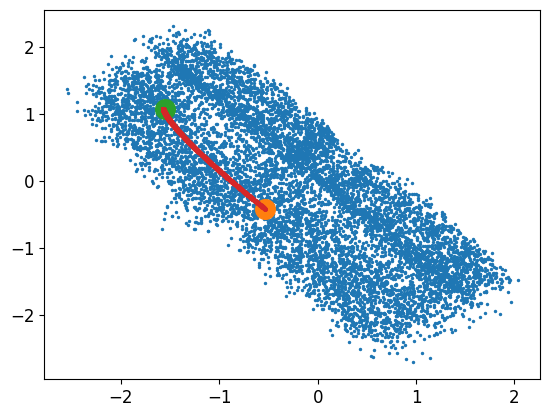

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
scprep.plot.scatter2d(z.detach().cpu().numpy(), ax=ax)
scprep.plot.scatter2d(xbatch[0].detach().cpu().numpy(), ax=ax)
scprep.plot.scatter2d(xfin[0].detach().cpu().numpy(), ax=ax)
scprep.plot.scatter2d(zhat_no_len_reg[:,0,:].detach().cpu().numpy(), ax=ax)

In [15]:
odemodel.pretraining = False
odemodel.lr = 1e-3
odemodel.lam=1
pretrainer = pl.Trainer(max_epochs=200)
pretrainer.fit(odemodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...
  rank_zero_warn(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: Pos

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [16]:
zhat = odemodel(xbatch)

<Axes: >

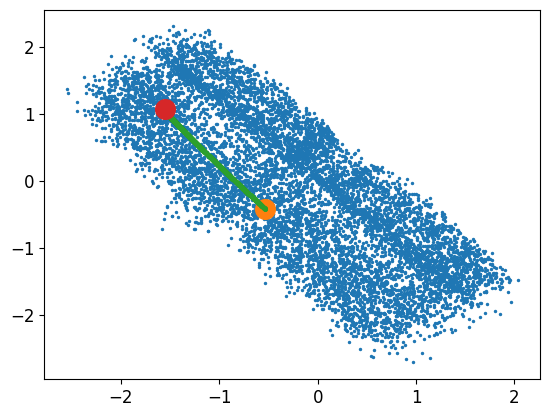

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
scprep.plot.scatter2d(z.detach().cpu().numpy(), ax=ax)
scprep.plot.scatter2d(xbatch[0].detach().cpu().numpy(), ax=ax)
scprep.plot.scatter2d(zhat[:,0,:].detach().cpu().numpy(), ax=ax)
scprep.plot.scatter2d(xfin[0].detach().cpu().numpy(), ax=ax)

In [18]:
out_pts = batch(x0)

NameError: name 'batch' is not defined

In [ ]:
t = torch.linspace(0,1,100)
z0 = z[:10,:]
odefunc = ODEFunc(2, 16)
zout = odeint(odefunc, z0, t)

In [ ]:
zout.shape

torch.Size([100, 10, 2])

In [ ]:
zout[-1].shape

torch.Size([10, 2])

In [ ]:
metric = pullback_metric(x_tensor_normalized, model.encoder)

In [ ]:
torch.einsum('Ni,Nij,Nj->N', x_tensor_normalized, metric, x_tensor_normalized).shape

torch.Size([3000])

In [ ]:
# for model.encoder.net[0]

In [ ]:
# dl = DeltaLengthNet(model.encoder)


In [ ]:
tswiss_roll = x_tensor_normalized
# Swiss roll random integer
npts = len(tswiss_roll)
start = np.random.randint(0,npts,size=1)
starttwo = np.random.randint(0,npts,size=1)
startthree = np.random.randint(0,npts,size=1)
startfour = np.random.randint(0,npts,size=1)
startfive= np.random.randint(0,npts,size=1)
end = np.random.randint(0,npts,size=1)
#Select start and end points for NeuralODE

x0 = torch.tensor(tswiss_roll[start,:]).cpu() #Start point
x1 = torch.tensor(tswiss_roll[starttwo,:]).cpu() 
x2 = torch.tensor(tswiss_roll[startthree,:]).cpu() 
x3 = torch.tensor(tswiss_roll[startfour,:]).cpu() 
x4 = torch.tensor(tswiss_roll[startfive,:]).cpu() 
xfin = torch.tensor(tswiss_roll[end,:]).cpu() 
xbatch = torch.cat((x0,x1,x2,x3,x4),0)
endbtch = torch.cat((xfin,xfin,xfin,xfin,xfin),0)


print(xfin.shape)
print(xbatch.shape)
print(endbtch.shape)

torch.Size([1, 3])
torch.Size([5, 3])
torch.Size([5, 3])


/tmp/tmp.OTD9fhobVM/ipykernel_835654/175121352.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(tswiss_roll[start,:]).cpu() #Start point
/tmp/tmp.OTD9fhobVM/ipykernel_835654/175121352.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(tswiss_roll[starttwo,:]).cpu()
/tmp/tmp.OTD9fhobVM/ipykernel_835654/175121352.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(tswiss_roll[startthree,:]).cpu()
/tmp/tmp.OTD9fhobVM/ipykernel_835654/175121352.py:15: UserWarning: To copy construct 

In [ ]:
batch_t = torch.linspace(0,1,2)

In [ ]:
xbatch

tensor([[-0.1956,  1.2660,  1.6567],
        [ 0.4090,  0.7648,  0.7226],
        [ 0.1463,  0.8104,  0.6780],
        [ 0.8805,  0.9799,  1.3358],
        [ 1.0704, -0.2958,  0.6806]])

In [ ]:
model.encoder(xbatch)

tensor([[ 2.9277, -9.8357],
        [ 1.2194,  2.6928],
        [10.2101, -0.0439],
        [-8.2807, -2.8404],
        [ 3.1774,  4.7731]], grad_fn=<AddmmBackward0>)

In [ ]:
# dl(batch_t, xbatch)

In [ ]:
xbatch

tensor([[-0.1956,  1.2660,  1.6567],
        [ 0.4090,  0.7648,  0.7226],
        [ 0.1463,  0.8104,  0.6780],
        [ 0.8805,  0.9799,  1.3358],
        [ 1.0704, -0.2958,  0.6806]])

In [ ]:
batch_t = torch.linspace(0, 1, 100)
odefunc = ODEFunc()
xs = odeint(odefunc, xbatch, batch_t)
ts = batch_t

In [ ]:
fcn = model.encoder
original_shape = xs.shape
xs_flat = xs.view(-1, xs.shape[2])
metric_flat = pullback_metric(xs_flat, fcn, create_graph=False, retain_graph=True)

In [ ]:
metric_flat.shape

torch.Size([500, 3, 3])

In [ ]:
class ODEFunc(nn.Module):

    def __init__(self, fcn):
        super(ODEFunc, self).__init__()
        self.fcn = fcn

        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 2), # coefficients
        )

    def forward(self, t, x):
        xs_flat = x.view(-1, xs.shape[2])
        coefs = self.net(xs_flat)
        jac = compute_jacobian_function(fcn, xs_flat, create_graph=True, retain_graph=True)
        U, S, Vt = torch.linalg.svd(jac, full_matrices=False)
        velo_flat = torch.einsum('ij,ijk->ik', coefs, Vt)
        velo = velo_flat.view(x.shape[0], x.shape[1], -1)
        return velo

fcn = model.encoder
odefunc = ODEFunc(fcn)

In [ ]:
original_shape = xs.shape
xs_flat = xs.view(-1, xs.shape[2])
# xs_flat = xs_flat.detach().clone()
xs_flat.requires_grad_(True)
jac = compute_jacobian_function(fcn, xs_flat, create_graph=False, retain_graph=True)
# metric_flat = pullback_metric(xs_flat, fcn, create_graph=False, retain_graph=True)
metric_flat = torch.einsum('Nki,Nkj->Nij', jac, jac)
xdot = odefunc(ts, xs)
xdot_flat = xdot.view(-1, xdot.shape[2])
l_flat = torch.sqrt(torch.einsum('Ni,Nij,Nj->N', xdot_flat, metric_flat, xdot_flat))
l = l_flat.view(original_shape[0], original_shape[1])
l_batch = l.mean(axis=0)

In [ ]:
xs_flat

tensor([[-0.1956,  1.2660,  1.6567],
        [ 0.4090,  0.7648,  0.7226],
        [ 0.1463,  0.8104,  0.6780],
        ...,
        [ 0.0764,  0.8725,  0.5668],
        [ 0.7312,  1.1494,  1.1908],
        [ 0.9777, -0.1643,  0.6917]], grad_fn=<ViewBackward0>)

In [ ]:
jac

tensor([[[  5.9738,   1.7593,  -4.4991],
         [  6.9808,   0.6456,  11.7341]],

        [[  2.7883,  -1.4000,   1.8339],
         [ -3.4731,  -1.0087,   1.4866]],

        [[  9.2566,   4.5395,   2.4293],
         [  3.2944,  -2.4549,   1.8112]],

        ...,

        [[ -2.7907,  -0.3447,   6.7974],
         [  4.1363,  -1.0368,   7.1594]],

        [[-12.2313,   0.9186,  -9.5081],
         [  2.2051,  -1.1680,  -5.7299]],

        [[-13.7632,  -1.8136, -33.5215],
         [  7.4836,   1.0632,  -3.3347]]])

In [ ]:
# scprep.plot.scatter3d(xs_flat.detach().cpu().numpy())

In [ ]:
U, S, Vt = torch.linalg.svd(jac, full_matrices=False)

In [ ]:
Vt.permute(0,2,1).shape

torch.Size([500, 3, 2])

In [ ]:
Vt

tensor([[[ 0.4745,  0.0371,  0.8795],
         [-0.8510, -0.2363,  0.4690]],

        [[ 0.9997, -0.0246,  0.0035],
         [-0.0173, -0.5892,  0.8078]],

        [[ 0.8998,  0.3528,  0.2567],
         [ 0.2680, -0.9112,  0.3128]],

        ...,

        [[ 0.1440, -0.1021,  0.9843],
         [ 0.9851, -0.0801, -0.1524]],

        [[-0.7582,  0.0487, -0.6502],
         [ 0.6280, -0.2137, -0.7483]],

        [[-0.3782, -0.0498, -0.9244],
         [ 0.9152,  0.1299, -0.3814]]])

In [ ]:
# torch.einsum('ni,ni->n', Vt[:,0,:], Vt[:,1,:])

In [ ]:
endbtch

tensor([[-1.0350,  1.0839,  0.8666],
        [-1.0350,  1.0839,  0.8666],
        [-1.0350,  1.0839,  0.8666],
        [-1.0350,  1.0839,  0.8666],
        [-1.0350,  1.0839,  0.8666]])

In [ ]:
xbatch

tensor([[-0.1956,  1.2660,  1.6567],
        [ 0.4090,  0.7648,  0.7226],
        [ 0.1463,  0.8104,  0.6780],
        [ 0.8805,  0.9799,  1.3358],
        [ 1.0704, -0.2958,  0.6806]])

In [ ]:
ode(batch_t, xbatch)

tensor([[ 0.0941,  0.0650,  0.0978],
        [ 0.0519, -0.0360,  0.0672],
        [ 0.1275,  0.0517,  0.0312],
        [ 0.1361,  0.0184, -0.0385],
        [-0.0176, -0.0065, -0.0898]], grad_fn=<AddmmBackward0>)

In [ ]:
odeint(ode, xbatch, batch_t)

tensor([[[ 1.2636, -1.1970,  0.0490],
         [ 1.1355,  0.8826, -0.7435],
         [ 0.7154, -0.8976,  0.5071],
         [ 0.1271, -0.2776,  0.7833],
         [-1.0314, -0.0115,  0.6272]],

        [[ 1.3732, -1.1329,  0.1448],
         [ 1.1956,  0.8479, -0.6767],
         [ 0.8547, -0.8465,  0.5392],
         [ 0.2690, -0.2591,  0.7487],
         [-1.0580, -0.0182,  0.5400]]], grad_fn=<CopySlices>)

In [ ]:
dl

DeltaLengthNet(
  (fcn): MLP(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=64, bias=True)
      (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (odefunc): ODEFunc(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=3, bias=True)
    )
  )
)

In [ ]:
xj = x_tensor_normalized[:100,:].clone()
xj.requires_grad = True
jac2 = torch.autograd.functional.jacobian(fcn, xj)

In [ ]:
xj = x_tensor_normalized[:100,:].clone()
xj.requires_grad = True
jac1 = compute_jacobian_function(fcn, xj, create_graph=False, retain_graph=True)

In [ ]:
xj

tensor([[-0.8684,  0.0236, -1.0067],
        [ 0.1840,  0.2444, -1.2358],
        [ 0.2437, -1.3371,  0.1722],
        [ 0.0489,  0.6453, -0.4259],
        [ 0.3651,  0.4967,  0.3923],
        [ 0.4829,  0.6382, -0.4590],
        [ 0.6718,  1.1707, -1.2243],
        [ 0.1208, -0.7065, -1.5939],
        [-1.1967, -1.2995,  0.1857],
        [-1.3850, -0.9415,  0.5508],
        [-0.0245,  1.2696, -0.8185],
        [ 0.7865, -0.8530, -1.0688],
        [-0.8079,  0.3914, -1.1201],
        [ 0.4048,  0.4748,  1.5497],
        [-0.1745,  0.1158, -1.3989],
        [-0.9508,  0.6480, -1.1287],
        [-1.3634,  0.9255,  0.4177],
        [ 0.5199,  0.7263,  0.4666],
        [-0.2398,  1.0528, -1.2614],
        [ 0.6575, -0.4875, -1.3386],
        [ 0.5762,  0.2497,  0.6565],
        [ 0.1421,  0.4722, -0.3928],
        [ 0.1000,  0.2369,  1.4754],
        [ 0.4500, -0.7788,  0.8218],
        [ 0.1868, -0.5579,  0.6494],
        [ 1.1157, -0.2390, -1.0569],
        [ 1.1488,  1.2061, -0.4805],
 

In [ ]:
jac2

tensor([[[[-1.6000e-01,  1.2661e+00,  7.0687e-01],
          [-8.0331e-02, -4.2649e-02, -1.2482e-01],
          [ 5.6130e-02,  1.2781e-02,  5.5852e-03],
          ...,
          [ 1.1844e-02, -1.0015e-01, -3.5252e-02],
          [ 9.6427e-02, -1.2403e-02, -3.5353e-02],
          [-4.5646e-03, -9.6671e-03, -3.0431e-02]],

         [[ 4.0855e+00,  1.5588e+00, -5.6226e+00],
          [ 1.1061e-01,  1.9104e-02,  1.1722e-01],
          [-8.5327e-02, -4.5160e-02,  4.8423e-02],
          ...,
          [-2.4106e-01, -1.2250e-01,  3.6439e-01],
          [-1.5442e-01, -8.9653e-02,  1.9829e-01],
          [ 2.7556e-02,  7.2798e-03,  7.6086e-02]]],


        [[[-2.3466e-02, -3.7578e-02,  5.1181e-02],
          [-2.8150e+00,  4.4632e-01, -6.3662e-01],
          [ 1.1519e-03,  1.3879e-02, -3.1905e-02],
          ...,
          [ 8.4265e-03, -2.8990e-02,  7.0546e-02],
          [ 1.3097e-01,  9.3238e-03,  1.6862e-01],
          [-6.4703e-02, -4.5413e-03, -1.6575e-01]],

         [[-7.3698e-02, -8.29

In [ ]:
jac1

tensor([[[-6.2720e-01,  7.2077e-02,  1.2819e+00],
         [ 1.9052e+00,  3.7060e-01, -1.6726e+00]],

        [[ 5.3103e-01,  4.5460e-01,  2.0450e+00],
         [ 6.8977e-01,  2.8719e-01,  3.3891e+00]],

        [[-3.4549e-01,  6.7609e-02,  5.4959e-01],
         [ 1.1801e+00, -9.2412e-01, -2.2275e+00]],

        [[ 4.2492e-01,  2.0359e-02,  4.6186e-01],
         [-2.0389e+00,  8.3883e-01,  1.3473e+00]],

        [[-3.8764e-01,  8.1049e-01,  1.4613e+00],
         [ 1.1917e+00, -2.1976e-01, -1.0997e+00]],

        [[ 4.2549e-01, -4.8525e-01,  2.0891e+00],
         [-8.0178e-01,  8.0972e-02, -1.8817e+00]],

        [[ 3.8723e-01,  1.7810e-01, -3.5687e+00],
         [ 4.5282e-01, -6.9495e-01,  1.8389e-02]],

        [[ 3.4725e-01,  5.0117e-01, -1.8377e-01],
         [-1.6966e-02,  3.3439e-01,  1.3539e-01]],

        [[-1.4895e+00, -4.5776e-01,  6.0408e-01],
         [-1.0796e+00,  5.8865e-02, -1.5685e+00]],

        [[ 1.5767e-01,  6.6500e-02,  5.0274e-01],
         [-1.8245e+00, -2.7839e-

In [ ]:
import numpy as np

In [ ]:
data = np.load('../data/eb_all.npz')

In [ ]:
data.files

['data', 'phate', 'dist', 'colors', 'is_train']

In [ ]:
data['colors']

array([0, 0, 0, ..., 4, 4, 4])